# Vision part
standard version: 26324 pairs rgb-depth (NYUv2 DIODE TUMRGB-D)

large version: 230766 pairs rgb-depth (standard + bonn scenenet)

In [3]:
import numpy as np
import h5py
import lmdb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
from PIL import Image
from bs4 import BeautifulSoup
import requests
import re
import os
import glob
import pathlib
import time
import datetime
import pprint
from ip_basic import depth_map_utils
# for nyu, tum, diode
def center_crop(im, new_width=None, new_height=None):
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return im.crop((left, top, right, bottom))
def show_example(path='/hy-tmp/stage2/rgb_depth_large.mat', idx=0):
    with  h5py.File(path,'r') as t:
        rgb = t['rgb']
        depth = t['depth']
        print(rgb.shape)
        rgbi = rgb[idx]
        depthi = depth[idx]
    fig=plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    xx = np.arange(0,256)
    yy = np.arange(0,256)
    X, Y = np.meshgrid(xx, yy)
    ax1.plot_surface(X,Y,depthi.squeeze(),cmap='rainbow')
    plt.show()
    plt.close()

    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(rgbi)
    ax2.imshow(depthi)
    plt.show()
    plt.close()
# for tum
def depth_completion(depthi, loop=2):
    '''ip_basic depth completion
    '''
    fill_type = 'fast'
    extrapolate = True
    blur_type = 'bilateral'
    for _ in range(loop):
        if fill_type == 'fast':
            depthi = depth_map_utils.fill_in_fast(
                depthi, extrapolate=extrapolate, blur_type=blur_type)
        elif fill_type == 'multiscale':
            depthi, process_dict = depth_map_utils.fill_in_multiscale(
                depthi, extrapolate=extrapolate, blur_type=blur_type,
                show_process=False)
    return depthi
def get_timestamp(v):
    f = v.split("/")[-1]
    stamp = f.replace(".png","")
    return float(stamp)
def align_rgb_depth(rgbs, depths, bi=True):
    '''Align two sequeces by timestamps in the filenames
    Use rgb as base
    '''
    if len(rgbs)==len(depths):
        return rgbs, depths
    res_rgbs = rgbs
    res_depths = []
    for i, v in enumerate(res_rgbs):
        target_stamp = get_timestamp(v)
        current_d = depths[0]
        if bi:
            # bi-search
            left = 0
            right = len(depths)-1
            while left<=right:
                mid = (left+right)//2
                now_stamp = get_timestamp(depths[mid])
                if now_stamp==target_stamp:
                    left=mid
                    right=mid-1
                elif now_stamp>target_stamp:
                    right = mid-1
                else:
                    left = mid+1
            if left==0:
                current_d = depths[left]
            elif right==len(depths)-1:
                current_d = depths[right]
            else:
                current_d = depths[left] if abs(get_timestamp(depths[left])-target_stamp)<abs(get_timestamp(depths[left-1])-target_stamp) else depths[left-1]
        else:
            current_min = 100000000
            for j, p in enumerate(depths):
                current_stamp = get_timestamp(p)
                if abs(target_stamp-current_stamp)<current_min:
                    current_min =  abs(target_stamp-current_stamp)
                    current_d = p
        res_depths.append(current_d)
    assert len(res_rgbs)==len(res_depths)
    return res_rgbs, res_depths

(230766, 224, 224, 3)


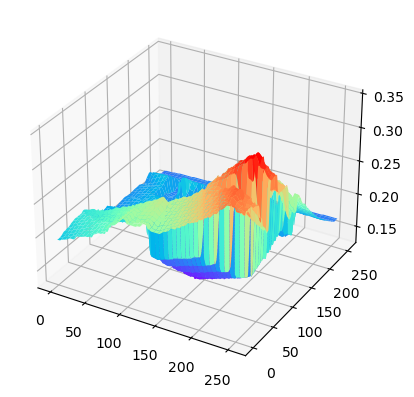

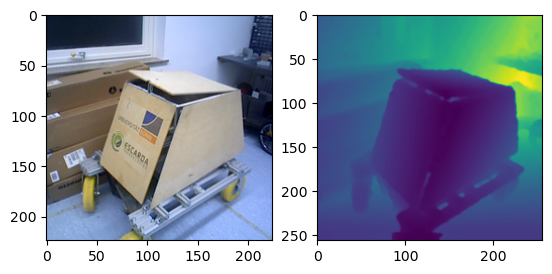

In [14]:
show_example(idx=60000)

## NYU V2
Download from http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
```
f["images"].shape = (1449,3,640,480)
f["depths"].shape = (1449,640,480)
```
process all images and depths into hdf5 datasets files
```
t["rgb"].shape = (1449, 224, 224, 3)
t["depth"].shape = (1449, 256, 256, 1)
```

In [4]:
MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 480
RGB_SIZE = 224
DEPTH_SIZE = 256
with h5py.File('/hy-tmp/nyuv2/nyu_depth_v2_labeled.mat','r') as f, h5py.File('/hy-tmp/stage2/rgb_depth.mat','a') as t:
    rgb = f['images']
    depth = f['depths']
    N = rgb.shape[0]
    if "rgb" in t:
        del t["rgb"]
    if "depth" in t:
        del t["depth"]
    target_rgb = t.create_dataset("rgb", shape=(0, RGB_SIZE, RGB_SIZE, 3), maxshape=(None, RGB_SIZE, RGB_SIZE, 3), dtype=np.uint8)
    target_depth = t.create_dataset("depth", shape=(0, DEPTH_SIZE, DEPTH_SIZE, 1), maxshape=(None, DEPTH_SIZE, DEPTH_SIZE, 1), dtype=float)
    for i in tqdm(range(N)):
        rgbi = rgb[i].transpose(2,1,0)
        rgbi = Image.fromarray(rgbi)
        rgbi = center_crop(rgbi, CROP_SIZE, CROP_SIZE)
        rgbi = rgbi.resize((RGB_SIZE,RGB_SIZE),resample=Image.Resampling.LANCZOS)
        rgbi = np.array(rgbi)
        target_rgb.resize(target_rgb.shape[0]+1, axis=0)
        target_rgb[-1:] = rgbi
        
        depthi = depth[i].transpose(1,0)
        depthi = np.clip(depthi, MIN_DEPTH, MAX_DEPTH)
        depthi = (depthi - MIN_DEPTH) / (
            MAX_DEPTH - MIN_DEPTH
        )
        depthi = Image.fromarray(depthi)
        depthi = center_crop(depthi, CROP_SIZE, CROP_SIZE)
        depthi = depthi.resize((DEPTH_SIZE,DEPTH_SIZE),resample=Image.Resampling.LANCZOS)
        depthi = np.array(depthi)
        depthi = np.expand_dims(depthi, axis=2)
        target_depth.resize(target_depth.shape[0]+1, axis=0)
        target_depth[-1:] = depthi

  0%|          | 0/1449 [00:00<?, ?it/s]

visualization

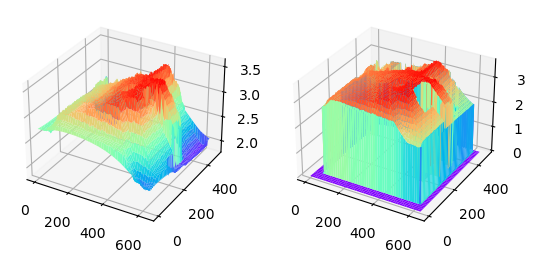

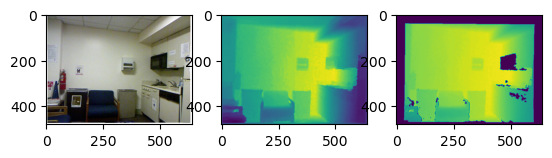

In [76]:
with h5py.File('/hy-tmp/nyuv2/nyu_depth_v2_labeled.mat','r') as f:
    rgb = f['images']
    depth = f['depths']
    rawdepth = f['rawDepths']
    rgbi = rgb[0].transpose(2,1,0)
    depthi = depth[0].transpose(1,0)
    rawdepthi = rawdepth[0].transpose(1,0)
fig=plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')
xx = np.arange(0,640)
yy = np.arange(0,480)
X, Y = np.meshgrid(xx, yy)
ax1.plot_surface(X,Y,depthi,cmap='rainbow')
ax2.plot_surface(X,Y,rawdepthi,cmap='rainbow')
plt.show()
plt.close()

fig=plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(rgbi)
ax2.imshow(depthi)
ax3.imshow(rawdepthi)
plt.show()
plt.close()

## TUM RGB-D
from page https://vision.in.tum.de/data/datasets/rgbd-dataset/download

We provide the time-stamped color and depth images as a gzipped tar file (TGZ).

+ The color images are stored as 640x480 8-bit RGB images in PNG format.
+ The depth maps are stored as 640x480 16-bit monochrome images in PNG format.
+ The color and depth images are already pre-registered using the OpenNI driver from PrimeSense, i.e., the pixels in the color and depth images correspond already 1:1.
+ The depth images are scaled by a factor of 5000, i.e., a pixel value of 5000 in the depth image corresponds to a distance of 1 meter from the camera, 10000 to 2 meter distance, etc. A pixel value of 0 means missing value/no data.

original videos are recorded with by 30 Hz

ignore the calibration and validation groups, totally 47 sequences

use bs4 to get all download links 

In [2]:
PREFIX = "https://vision.in.tum.de/"
res = requests.get("https://vision.in.tum.de/data/datasets/rgbd-dataset/download")
soup = BeautifulSoup(res.text)
linktags = soup.find_all('a', href=re.compile("/rgbd/dataset.*?tgz"))
linktags = linktags[:(len(linktags)//2)]
links = []
for a in linktags:
    relative = a.get("href")
    if "checkerboard_large" not in relative and "calibration" not in relative and "validation" not in relative:
        links.append(PREFIX+relative)
# only validation
links_val = []
for a in linktags:
    relative = a.get("href")
    if  "validation" in relative:
        links_val.append(PREFIX+relative)

Download

In [4]:
# FOLDER = "/hy-tmp/tumrgbd/"
# for link in links:
#     cmd = "wget -P %s -q %s"%(FOLDER, link)
#     os.system(cmd)

Decompress

In [9]:
# FOLDER = "/hy-tmp/tumrgbd/"
# tar_files = glob.glob(FOLDER+"*")
# for v in tar_files:
#     cmd = "tar -zxf %s -C %s"%(v, FOLDER)
#     os.system(cmd)

To HDF5

Due to the different numbers of rgb images and depth images in a sequence, we need to delete tail images.

Due to the too many images, we need to downsample on the temporal dimension 

(Every 5 choose 1, totally 16301 samples).

(Every 2 choose 1, totally 40721 samples).

In [5]:
FOLDER = "/hy-tmp/tumrgbd/"
MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 480
RGB_SIZE = 224
DEPTH_SIZE = 256
DOWNSAMPLE_RATE = 5 # or 2

with h5py.File('/hy-tmp/stage2/rgb_depth.mat','a') as t:
    target_rgb = t["rgb"]
    target_depth = t["depth"]
    # print(target_rgb.shape)
    total = 0
    for sequence in tqdm(glob.glob(FOLDER+"*/")):
        rgbs = sorted(glob.glob(sequence+"rgb/*"))
        depths = sorted(glob.glob(sequence+"depth/*"))
        rgbs, depths = align_rgb_depth(rgbs, depths, bi=True)
        rgbs = rgbs[::DOWNSAMPLE_RATE]
        depths = depths[::DOWNSAMPLE_RATE]
        N = len(rgbs)
        total += N
        for i in tqdm(range(N), leave=False):
            rgbi = Image.open(rgbs[i])
            rgbi = center_crop(rgbi, CROP_SIZE, CROP_SIZE)
            rgbi = rgbi.resize((RGB_SIZE,RGB_SIZE),resample=Image.Resampling.LANCZOS)
            rgbi = np.array(rgbi)
            target_rgb.resize(target_rgb.shape[0]+1, axis=0)
            target_rgb[-1:] = rgbi
            
            depthi = Image.open(depths[i])
            depthi = np.array(depthi).astype('float32')/5000.0
            depthi = np.clip(depthi, MIN_DEPTH, MAX_DEPTH)
            depthi = depth_completion(depthi)
            depthi = (depthi - MIN_DEPTH) / (
                MAX_DEPTH - MIN_DEPTH
            )
            depthi = Image.fromarray(depthi)
            depthi = center_crop(depthi, CROP_SIZE, CROP_SIZE)
            depthi = depthi.resize((DEPTH_SIZE,DEPTH_SIZE),resample=Image.Resampling.LANCZOS)
            depthi = np.array(depthi)
            depthi = np.clip(depthi, 0.0, 1.0)
            depthi = np.expand_dims(depthi, axis=2)
            target_depth.resize(target_depth.shape[0]+1, axis=0)
            target_depth[-1:] = depthi
            
            assert depthi.max()<=1, "wrong"
            assert depthi.min()>=0, "wrong"
        # pprint.pprint(list(zip(rgbs, depths)))
        # break
    print(total)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/1835 [00:00<?, ?it/s]

  0%|          | 0/1645 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/621 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/681 [00:00<?, ?it/s]

  0%|          | 0/1365 [00:00<?, ?it/s]

  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/2591 [00:00<?, ?it/s]

  0%|          | 0/1293 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/1461 [00:00<?, ?it/s]

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/541 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/430 [00:00<?, ?it/s]

  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 0/1504 [00:00<?, ?it/s]

  0%|          | 0/1486 [00:00<?, ?it/s]

  0%|          | 0/1149 [00:00<?, ?it/s]

  0%|          | 0/1129 [00:00<?, ?it/s]

  0%|          | 0/931 [00:00<?, ?it/s]

  0%|          | 0/574 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/1205 [00:00<?, ?it/s]

40721


Test depth completion

In [214]:
del depth_map_utils
from ip_basic import depth_map_utils
def depth_completion(depthi, loop=3):
    fill_type = 'multiscale'
    extrapolate = False
    blur_type = 'bilateral'
    for _ in range(loop):
        if fill_type == 'fast':
            depthi = depth_map_utils.fill_in_fast(
                depthi, extrapolate=extrapolate, blur_type=blur_type)
        elif fill_type == 'multiscale':
            depthi, process_dict = depth_map_utils.fill_in_multiscale(
                depthi, extrapolate=extrapolate, blur_type=blur_type,
                show_process=False)
    return depthi
img1 = Image.open("/hy-tmp/tumrgbd/rgbd_dataset_freiburg1_xyz/depth/1305031105.497931.png")
img = np.array(img1).astype('float32')/5000.0
# img1 = np.array(img1)/5000.0
res = depth_completion(img.copy())

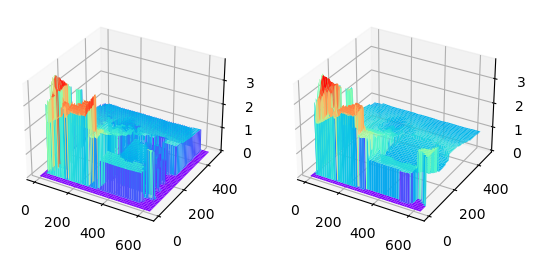

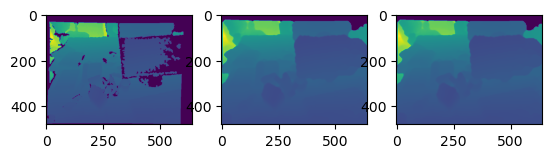

3.799 3.7190552


In [215]:
fig=plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')
xx = np.arange(0,640)
yy = np.arange(0,480)
X, Y = np.meshgrid(xx, yy)
ax1.plot_surface(X,Y,img,cmap='rainbow')
ax2.plot_surface(X,Y,res,cmap='rainbow')
plt.show()
plt.close()

fig=plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(img)
ax2.imshow(res)
ax3.imshow(res)
plt.show()
plt.close()
print(img.max(), res.max())

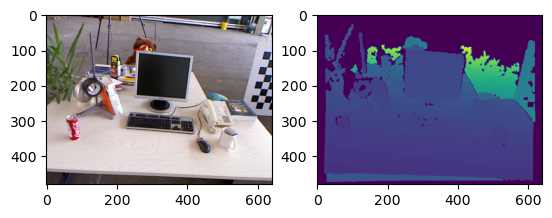

In [241]:
from PIL import Image
import matplotlib.pyplot as plt
img_rgb = Image.open("/hy-tmp/tumrgbd/rgbd_dataset_freiburg2_rpy/rgb/1311867828.100314.png")
img_rgb = np.array(img_rgb)
# img_rgb = img_rgb.astype(float)/(img.max()+5)

img_d = Image.open("/hy-tmp/tumrgbd/rgbd_dataset_freiburg2_rpy/depth/1311867827.231373.png")
img_d = np.array(img_d)
figure, axs = plt.subplots(1,2)
axs[0].imshow(img_rgb)
axs[1].imshow(img_d)

(26324, 224, 224, 3)


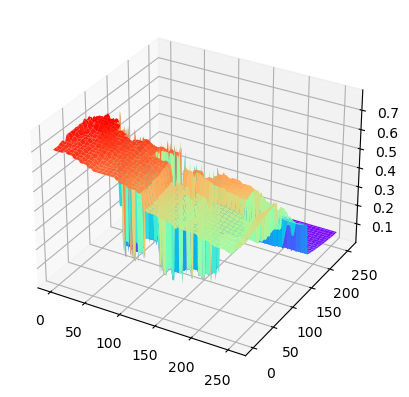

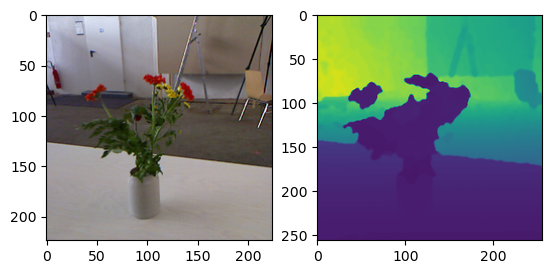

In [287]:
show_example(idx=15000)

## DIODE
from page https://diode-dataset.org/

8574 indoor and 16884 outdoor samples

![](https://hzt-1307384245.cos.ap-shanghai.myqcloud.com/markdown/202301251021223.png)


In [6]:
FOLDER_INDOOR = "/hy-tmp/diode/train/indoors/"
FOLDER_OUTDOOR = "/hy-tmp/diode/train/outdoors/"
MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 768
RGB_SIZE = 224
DEPTH_SIZE = 256

rgb_files = sorted(glob.glob(FOLDER_INDOOR+"*/*/*.png"))
depth_files = sorted(glob.glob(FOLDER_INDOOR+"*/*/*_depth.npy"))

with h5py.File('/hy-tmp/stage2/rgb_depth.mat','a') as t:
    target_rgb = t["rgb"]
    target_depth = t["depth"]
    for i in trange(len(rgb_files)):
        rgbi = Image.open(rgb_files[i])
        rgbi = center_crop(rgbi, CROP_SIZE, CROP_SIZE)
        rgbi = rgbi.resize((RGB_SIZE,RGB_SIZE),resample=Image.Resampling.LANCZOS)
        rgbi = np.array(rgbi)
        target_rgb.resize(target_rgb.shape[0]+1, axis=0)
        target_rgb[-1:] = rgbi

        depthi = np.load(depth_files[i]).squeeze()
        depthi = np.clip(depthi, MIN_DEPTH, MAX_DEPTH)
        if depthi.min()==0:
            depthi = depth_completion(depthi,loop=1)
        depthi = (depthi - MIN_DEPTH) / (
            MAX_DEPTH - MIN_DEPTH
        )
        depthi = Image.fromarray(depthi)
        depthi = center_crop(depthi, CROP_SIZE, CROP_SIZE)
        depthi = depthi.resize((DEPTH_SIZE,DEPTH_SIZE),resample=Image.Resampling.LANCZOS)
        depthi = np.array(depthi)
        depthi = np.clip(depthi, 0.0, 1.0)
        depthi = np.expand_dims(depthi, axis=2)
        target_depth.resize(target_depth.shape[0]+1, axis=0)
        target_depth[-1:] = depthi

  0%|          | 0/8574 [00:00<?, ?it/s]

visualization

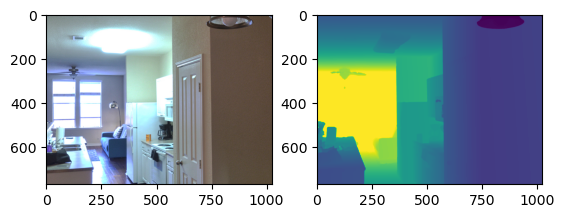

In [260]:
FOLDER_INDOOR = "/hy-tmp/diode/train/indoors/"
FOLDER_OUTDOOR = "/hy-tmp/diode/train/outdoor/"
rgb_files = sorted(glob.glob(FOLDER_INDOOR+"*/*/*.png"))
depth_files = sorted(glob.glob(FOLDER_INDOOR+"*/*/*_depth.npy"))
rgb_fileso = sorted(glob.glob(FOLDER_OUTDOOR+"*/*/*.png"))
depth_fileso = sorted(glob.glob(FOLDER_OUTDOOR+"*/*/*_depth.npy"))
rgb = Image.open(rgb_files[1000])
rgb = np.array(rgb)
depth = np.load(depth_files[1000])
depth[depth>10] = 10
depth = depth_completion(depth,loop=1)
fig=plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(rgb)
ax2.imshow(depth.squeeze())
plt.show()
plt.close()

(26324, 224, 224, 3)


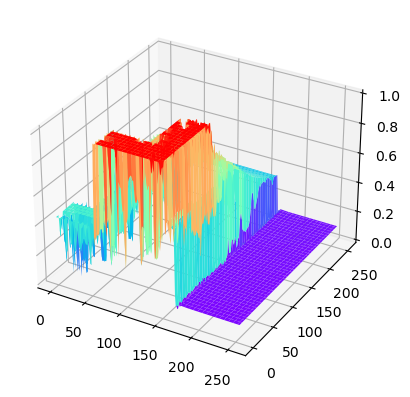

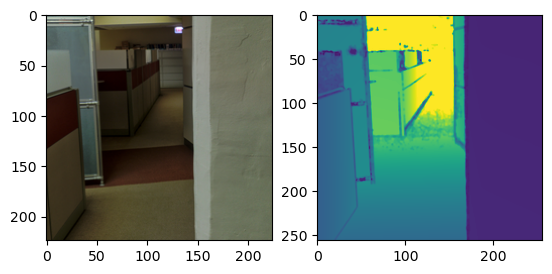

In [286]:
show_example(idx=25000)

(50744, 224, 224, 3)


## BonnRGBD
from http://www.ipb.uni-bonn.de/data/rgbd-dynamic-dataset/

26 sequences for rgb-d SLAM (24 dynamic, 2 static), same format as TUM

30022 samples

only for large version

In [22]:
FOLDER = "/hy-tmp/bonnrgbd/rgbd_bonn_dataset/"
MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 480
RGB_SIZE = 224
DEPTH_SIZE = 256
DOWNSAMPLE_RATE = 1 # or 2

with h5py.File('/hy-tmp/stage2/rgb_depth_large.mat','a') as t:
    target_rgb = t["rgb"]
    target_depth = t["depth"]
    # print(target_rgb.shape)
    total = 0
    for sequence in tqdm(glob.glob(FOLDER+"*/")):
        rgbs = sorted(glob.glob(sequence+"rgb/*"))
        depths = sorted(glob.glob(sequence+"depth/*"))
        rgbs, depths = align_rgb_depth(rgbs, depths, bi=True)
        rgbs = rgbs[::DOWNSAMPLE_RATE]
        depths = depths[::DOWNSAMPLE_RATE]
        assert len(rgbs)==len(depths)
        N = len(rgbs)
        total += N
        for i in tqdm(range(N), leave=False):
            rgbi = Image.open(rgbs[i])
            rgbi = center_crop(rgbi, CROP_SIZE, CROP_SIZE)
            rgbi = rgbi.resize((RGB_SIZE,RGB_SIZE),resample=Image.Resampling.LANCZOS)
            rgbi = np.array(rgbi)
            target_rgb.resize(target_rgb.shape[0]+1, axis=0)
            target_rgb[-1:] = rgbi

            depthi = Image.open(depths[i])
            depthi = np.array(depthi).astype('float32')/5000.0
            depthi = np.clip(depthi, MIN_DEPTH, MAX_DEPTH)
            depthi = depth_completion(depthi)
            depthi = (depthi - MIN_DEPTH) / (
                MAX_DEPTH - MIN_DEPTH
            )
            depthi = Image.fromarray(depthi)
            depthi = center_crop(depthi, CROP_SIZE, CROP_SIZE)
            depthi = depthi.resize((DEPTH_SIZE,DEPTH_SIZE),resample=Image.Resampling.LANCZOS)
            depthi = np.array(depthi)
            depthi = np.clip(depthi, 0.0, 1.0)
            depthi = np.expand_dims(depthi, axis=2)
            target_depth.resize(target_depth.shape[0]+1, axis=0)
            target_depth[-1:] = depthi

            assert depthi.max()<=1, "wrong"
            assert depthi.min()>=0, "wrong"

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/1752 [00:00<?, ?it/s]

  0%|          | 0/10916 [00:00<?, ?it/s]

  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/677 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/567 [00:00<?, ?it/s]

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/1294 [00:00<?, ?it/s]

  0%|          | 0/1091 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/928 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

visualization

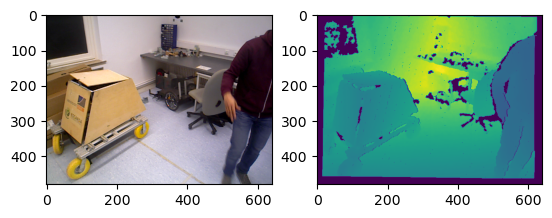

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
img_rgb = Image.open("/hy-tmp/bonnrgbd/rgbd_bonn_dataset/rgbd_bonn_balloon2/rgb/1548266545.99617.png")
img_rgb = np.array(img_rgb)
# img_rgb = img_rgb.astype(float)/(img.max()+5)

img_d = Image.open("/hy-tmp/bonnrgbd/rgbd_bonn_dataset/rgbd_bonn_balloon2/depth/1548266545.98981.png")
img_d = np.array(img_d)
figure, axs = plt.subplots(1,2)
axs[0].imshow(img_rgb)
axs[1].imshow(img_d)

(80766, 224, 224, 3)


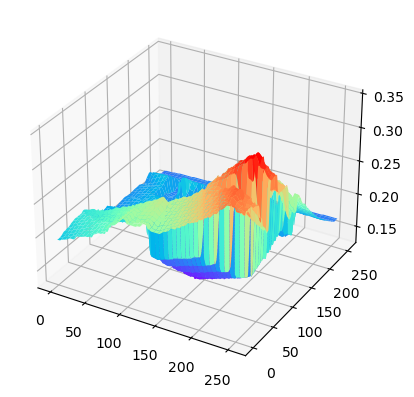

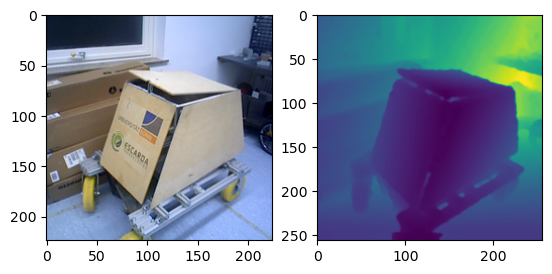

In [23]:
show_example(path='/hy-tmp/stage2/rgb_depth_large.mat',idx=60000)

In [24]:
total

30022

## SceneNet
from https://robotvault.bitbucket.io/scenenet-rgbd.html

The dataset consists of two components. The first component is a set of files organised into trajectory folders. Each of these folders contains three directorys:

+ photo - which contains the photorealistic renders, each of which is named after its frame_num (e.g. 0.jpg is the first pose, 25.jpg the next)
+ depth - which contains the accompanying depth information stored as unsigned 16-bit integers within a PNG. The numbering scheme is the same as for photo (0.png is the first frame). The units are millimeters, a value of 1000 is a meter. Depth is defined as the euclidean ray length from the camera position to the first point of intersection.


currently use tarball train10.tar.gz

150000 samples, downsample=2

only for large version

In [70]:
FOLDER = "/hy-tmp/scenenet/train/10/"
MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 240
RGB_SIZE = 224
DEPTH_SIZE = 256
DOWNSAMPLE_RATE = 2 # or 2
res = glob.glob(FOLDER+"*/")

In [77]:
with h5py.File('/hy-tmp/stage2/rgb_depth_large.mat','a') as t:
    target_rgb = t["rgb"]
    target_depth = t["depth"]
    # print(target_rgb.shape)
    total = 0
    for sequence in tqdm(glob.glob(FOLDER+"*/")):
        rgbs = sorted(glob.glob(sequence+"photo/*"))
        depths = sorted(glob.glob(sequence+"depth/*"))
        rgbs, depths = align_rgb_depth(rgbs, depths, bi=True)
        rgbs = rgbs[::DOWNSAMPLE_RATE]
        depths = depths[::DOWNSAMPLE_RATE]
        assert len(rgbs)==len(depths)
        N = len(rgbs)
        total += N
        for i in tqdm(range(N), leave=False):
            rgbi = Image.open(rgbs[i])
            rgbi = center_crop(rgbi, CROP_SIZE, CROP_SIZE)
            rgbi = rgbi.resize((RGB_SIZE,RGB_SIZE),resample=Image.Resampling.LANCZOS)
            rgbi = np.array(rgbi)
            target_rgb.resize(target_rgb.shape[0]+1, axis=0)
            target_rgb[-1:] = rgbi

            depthi = Image.open(depths[i])
            depthi = np.array(depthi).astype('float32')/1000.0
            if depthi.min()==0:
                depthi = depth_completion(depthi)
            depthi = np.clip(depthi, MIN_DEPTH, MAX_DEPTH)
            depthi = (depthi - MIN_DEPTH) / (
                MAX_DEPTH - MIN_DEPTH
            )
            depthi = Image.fromarray(depthi)
            depthi = center_crop(depthi, CROP_SIZE, CROP_SIZE)
            depthi = depthi.resize((DEPTH_SIZE,DEPTH_SIZE),resample=Image.Resampling.LANCZOS)
            depthi = np.array(depthi)
            depthi = np.clip(depthi, 0.0, 1.0)
            depthi = np.expand_dims(depthi, axis=2)
            target_depth.resize(target_depth.shape[0]+1, axis=0)
            target_depth[-1:] = depthi

            assert depthi.max()<=1, "wrong"
            assert depthi.min()>=0, "wrong"
print(total)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

150000


visualization

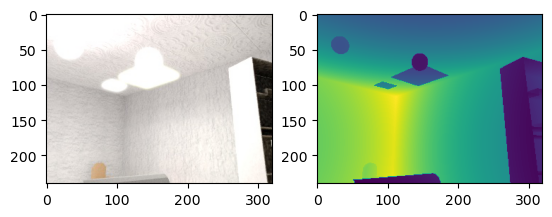

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
img_rgb = Image.open("/hy-tmp/scenenet/train/10/10051/photo/100.jpg")
img_rgb = np.array(img_rgb)
# img_rgb = img_rgb.astype(float)/(img.max()+5)

img_d = Image.open("/hy-tmp/scenenet/train/10/10051/depth/100.png")
img_d = np.array(img_d)
figure, axs = plt.subplots(1,2)
axs[0].imshow(img_rgb)
axs[1].imshow(img_d)

(230766, 224, 224, 3)


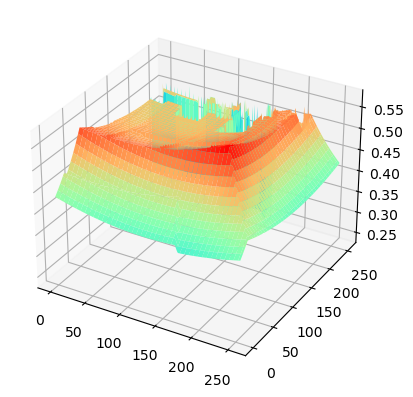

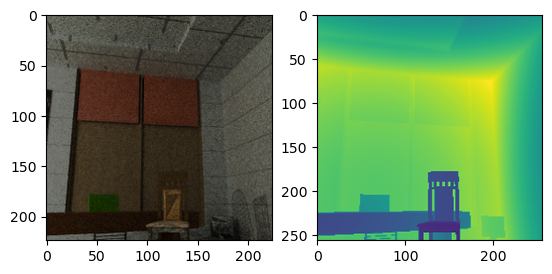

In [80]:
show_example(path='/hy-tmp/stage2/rgb_depth_large.mat',idx=220000)

# Language part
stadard version: 28427 samples inst-sub (touchdown map2seq chalet)

large version: 157877 samples inst-sub (standard + talkthewalk alfred)

In [1]:
import copy
import gzip
import itertools
import json
import pickle
import random
import re
import threading
import time
from collections import Counter
import glob

import h5py
import clip
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from nltk.tokenize import PunktSentenceTokenizer
from numba import jit
from PIL import Image
from tqdm.notebook import tqdm
import pickle
import pathlib
from nltk.tokenize import PunktSentenceTokenizer
random.seed(25)
np.random.seed(25)
def instruction_cut_clip(episodes, append_dot=False, keep_subs=True, refine=False, split_func=None, lower_all=False):
    """
    Params:
        episodes: a dataset list, [{"instruction_text":""}]
        append_dot: whether to add a "." at the end of sub-instructions
        keep_subs: whether to keep sub-instruction text after processing
        refine: whether to use proposed refine processing
        split_func: the function used to cut instructions, default is `nltk.sent_tokenize`
        lower_all: whether to lower all characters in sub-instructions.
    Return:
        train_data with "sub_instruction_tokens" and "sub_instruction"
    """
    if split_func is None:
        split_func = nltk.sent_tokenize
    print(split_func)
    train_data = copy.deepcopy(episodes)
    # pre process
    char_pattern = re.compile(r"[a-zA-Z]")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        inst = inst.strip()
        start_idx = 0
        while not char_pattern.search(inst[start_idx]):
            start_idx += 1
        inst = inst[start_idx:]
        if lower_all:
            inst = inst.lower()
        train_data[i]["instruction_text"] = inst.replace("...", ".").replace("..", ".").replace(".",". ").replace("  ", " ")
    
    # cut by nltk
    pattern = re.compile(r"\r\n")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        res = []
        now = pattern.split(inst)
        for v in now:
            res.extend(split_func(v))
        train_data[i]["sub_instruction"] = [piece.strip() for piece in res if piece.strip()]
    # refine
    if refine:
        punctuation_list = [",", "."]
        char_pattern = re.compile(r"[a-zA-Z]+")
        def judge_verb(word):
            const_verbs = ["wait", "turn", "walk", "stop"]
            if "VB" in word[1]:
                return True
            if word[0] in const_verbs:
                return True
            return False
        for i, item in enumerate(tqdm(train_data)):
            new_sub = []
            for k, piece in enumerate(item["sub_instruction"]):
                word_list = nltk.pos_tag(nltk.word_tokenize(piece))
                tmp = ""
                for x, word in enumerate(word_list):
                    if (word[0].lower()=="and" or word[0]=="," or word[0].lower()=="then") and (x+1<len(word_list) and judge_verb(word_list[x+1])):
                        if tmp and char_pattern.search(tmp):
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                            
                    elif (word[0]=="and" or word[0]==",") and (x+1<len(word_list) and word_list[x+1][0]=="then"):
                        if tmp:
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                    else:
                        if not tmp or word[0] in punctuation_list:
                            tmp+=word[0]
                        else:
                            tmp+=(" "+word[0])
                if tmp:
                    new_sub.append(tmp)
            train_data[i]["sub_instruction"] = new_sub
    
    # post process and generate tokens
    char_pattern = re.compile(r"[a-zA-Z]")
    max_len = 0
    pad_index = 0
    pad_len = 86 # 0.09%
    sub_pad_len = 77 # 0.05%
    sub_num = 12 # 0.04%
    useless_sub = [pad_index]*sub_pad_len
    sub_split_index = -1
    for i, item in enumerate(tqdm(train_data)):
        tokens_all = []
        tokens_split = []
        for k, piece in enumerate(item["sub_instruction"]):
            piece = piece.strip()
            assert piece
            idx = len(piece)-1
            while idx>=0 and piece[idx] in [".", ","]:
                idx -= 1
            if append_dot:
                piece = piece[0:(idx+1)]+"."
            else:
                piece = piece[0:(idx+1)]
            piece = piece.replace("``", "\"").replace("''", "\"")
            train_data[i]["sub_instruction"][k] = piece
            piece_tokens = clip.tokenize(piece, truncate=True).squeeze(0).tolist()
            tokens_split.append(piece_tokens)
        if len(tokens_split)>sub_num:
            tokens_split = tokens_split[0:sub_num]
        tokens_split.extend([useless_sub]*(sub_num-len(tokens_split)))
        
        train_data[i]["instruction_tokens"] = clip.tokenize(item["instruction_text"], truncate=True, context_length=77).squeeze(0).tolist()
        train_data[i]["sub_instruction_tokens"] = tokens_split
        if not keep_subs:
            del item["sub_instruction"]
    return train_data

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
def random_chunks(lst, left, right):
    """Yield successive n-sized chunks from lst."""
    i = 0
    n = len(lst)
    while i<n:
        k = random.randint(left,right)
        yield lst[i:min(i+k, n)]
        i += k

## Touchdown
https://github.com/lil-lab/touchdown

totally 9325 samples

15532 samples after processing

21609 samples for large version

In [2]:
# Read
FOLDER = "/hy-tmp/touchdown/data/"
SPLITS = ["dev.json","train.json","test.json"]
data = []
for split in SPLITS:
    with open(FOLDER+split,"r",encoding="utf-8") as f:
        for line in f.readlines():
            data.append(json.loads(line))
raw_instructions = [{"instruction_text":v["navigation_text"]} for v in data]
all_text = " ".join(v["navigation_text"] for v in data)
sent_tokenizer = PunktSentenceTokenizer(all_text)

In [3]:
# Split because too long
instructions = []
cnt = 0
limit = 5
left = 2
right = 4
# limit = 1
# left = 2
# right = 5
for v in tqdm(raw_instructions):
    res = sent_tokenizer.tokenize(v["instruction_text"])
    res = [v for v in res if len(v)>3]
    if len(res)>=limit:
        for t in random_chunks(res,left,right):
            instructions.append(" ".join(t))
    else:
        instructions.append(" ".join(res))
instructions = [{"instruction_text":v} for v in instructions]
print(len(instructions), cnt)

  0%|          | 0/9325 [00:00<?, ?it/s]

21609 0


sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=sent_tokenizer.tokenize)sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=sent_tokenizer.tokenize)FSA

In [4]:
sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=sent_tokenizer.tokenize)

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x14ee6c86e820>>


  0%|          | 0/21609 [00:00<?, ?it/s]

  0%|          | 0/21609 [00:00<?, ?it/s]

  0%|          | 0/21609 [00:00<?, ?it/s]

  0%|          | 0/21609 [00:00<?, ?it/s]

To HDF5

In [6]:
SUB_LEN = 12
INST_LEN = 77
with h5py.File('/hy-tmp/stage2/inst_sub_large.mat','a') as t:
    if "instructions" in t:
        del t["instructions"]
    if "sub_instructions" in t:
        del t["sub_instructions"]
    target_inst = t.create_dataset("instructions", shape=(0, INST_LEN), maxshape=(None, INST_LEN), dtype=np.int32)
    target_sub = t.create_dataset("sub_instructions", shape=(0, SUB_LEN, INST_LEN), maxshape=(None, SUB_LEN, INST_LEN), dtype=np.int32)
    for v in tqdm(sub_data):
        insti = v["instruction_tokens"]
        subi = v["sub_instruction_tokens"]
        
        target_inst.resize(target_inst.shape[0]+1, axis=0)
        target_inst[-1:] = np.array(insti, dtype=np.int32)
        
        target_sub.resize(target_sub.shape[0]+1, axis=0)
        target_sub[-1:] = np.array(subi, dtype=np.int32)
    print(target_inst.shape, target_sub.shape)

  0%|          | 0/21609 [00:00<?, ?it/s]

(21609, 77) (21609, 12, 77)


statics

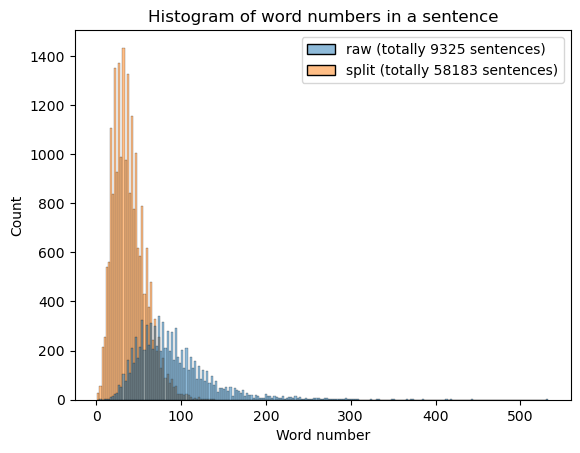

0.5526005361930295
0.040307279374334766


In [7]:
raw_word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in raw_instructions]
word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw (totally 9325 sentences)":raw_word_numbers,"split (totally 58183 sentences)":word_numbers}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()
limit = 77
raw_word_numbers = np.array(raw_word_numbers)
word_numbers = np.array(word_numbers)
print((raw_word_numbers>=77).sum()/len(raw_word_numbers))
print((word_numbers>=77).sum()/len(word_numbers))

3.59743625341293


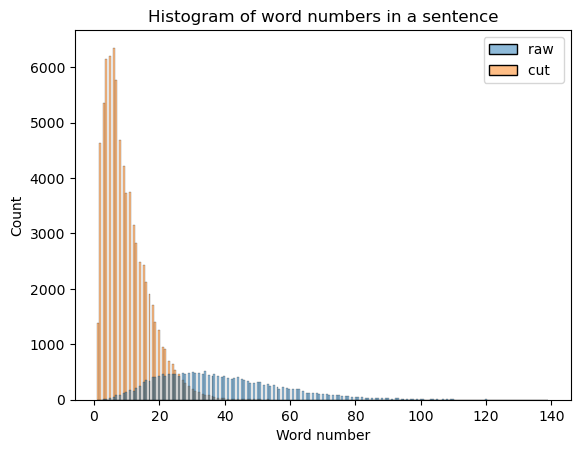

In [8]:
print(np.mean([len(v["sub_instruction"]) for v in sub_data]))
sub_instructions = [v["sub_instruction"] for v in sub_data]
raw_len_list = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
sub_len_list = [len(nltk.word_tokenize(v)) for v in list(itertools.chain.from_iterable(sub_instructions))]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw ":raw_len_list,"cut ":sub_len_list}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()

## map2seq
https://map2seq.schumann.pub/dataset/download/

totally 7672 samples (train, val, test)

In [9]:
# Read
FOLDER = "/hy-tmp/map2seq/splits/"
SPLITS = ["test_seen.json","test_unseen.json","train.json","val.json"]
raw_instructions = []
for split in SPLITS:
    with open(FOLDER+split,"r",encoding="utf-8") as f:
        data = json.loads(f.read())
    raw_instructions.extend([{"instruction_text":v["instructions"]} for v in data])
all_text = " ".join(v["instruction_text"] for v in raw_instructions)
sent_tokenizer = PunktSentenceTokenizer(all_text)

In [10]:
len(raw_instructions)

7672

FSA

In [11]:
sub_data = instruction_cut_clip(raw_instructions, refine=True, append_dot=False, split_func=sent_tokenizer.tokenize)

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x14eb911b7af0>>


  0%|          | 0/7672 [00:00<?, ?it/s]

  0%|          | 0/7672 [00:00<?, ?it/s]

  0%|          | 0/7672 [00:00<?, ?it/s]

  0%|          | 0/7672 [00:00<?, ?it/s]

To HDF5

In [12]:
SUB_LEN = 12
INST_LEN = 77
with h5py.File('/hy-tmp/stage2/inst_sub_large.mat','a') as t:
    target_inst = t["instructions"]
    target_sub = t["sub_instructions"]
    for v in tqdm(sub_data):
        insti = v["instruction_tokens"]
        subi = v["sub_instruction_tokens"]
        
        target_inst.resize(target_inst.shape[0]+1, axis=0)
        target_inst[-1:] = np.array(insti, dtype=np.int32)
        
        target_sub.resize(target_sub.shape[0]+1, axis=0)
        target_sub[-1:] = np.array(subi, dtype=np.int32)
    print(target_inst.shape, target_sub.shape)

  0%|          | 0/7672 [00:00<?, ?it/s]

(29281, 77) (29281, 12, 77)


statics

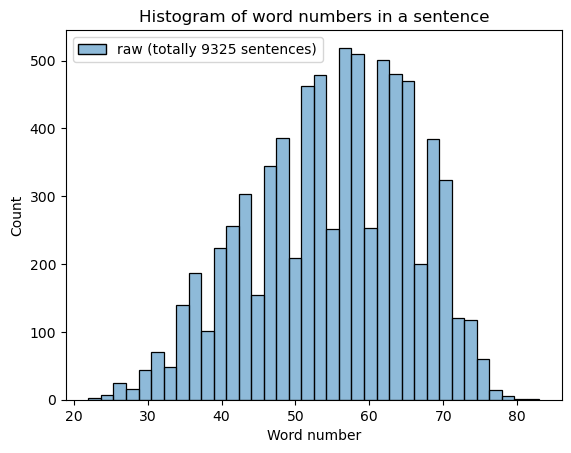

0.002867570385818561


In [13]:
raw_word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in raw_instructions]
# word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw (totally 9325 sentences)":raw_word_numbers,}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()
limit = 77
raw_word_numbers = np.array(raw_word_numbers)
print((raw_word_numbers>=77).sum()/len(raw_word_numbers))
# word_numbers = np.array(word_numbers)
# print((word_numbers>=77).sum()/len(word_numbers))

6.1895203336809175


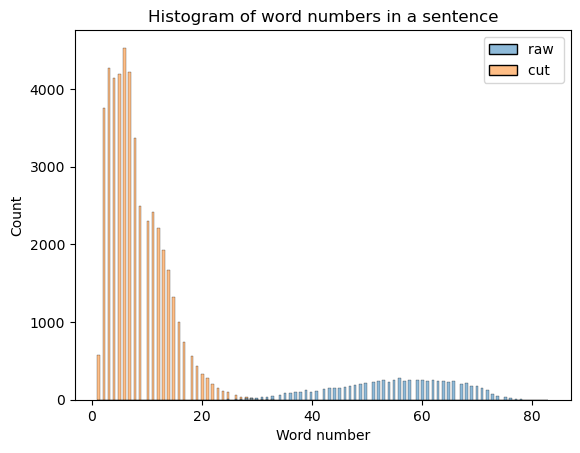

In [14]:
print(np.mean([len(v["sub_instruction"]) for v in sub_data]))
sub_instructions = [v["sub_instruction"] for v in sub_data]
raw_len_list = [len(nltk.word_tokenize(v["instruction_text"])) for v in raw_instructions]
sub_len_list = [len(nltk.word_tokenize(v)) for v in list(itertools.chain.from_iterable(sub_instructions))]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw ":raw_len_list,"cut ":sub_len_list}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.savefig("tmp4.jpg",dpi=100, bbox_inches = 'tight')
plt.show()

## CHALET
https://github.com/lil-lab/chalet

totally 3642 samples

5223 samples after processing

5860 samples for large

In [15]:
# Read
PATH = "/hy-tmp/chalet/text2traj_instructions_2018_emnlp_instructions.csv"
data = pd.read_csv(PATH)
raw_instructions = []
for i, sample in data.iterrows():
    raw_instructions.append({"instruction_text":sample["inst1"].replace("\r\n", " ")})
    raw_instructions.append({"instruction_text":sample["inst2"].replace("\r\n", " ")})

all_text = " ".join(v["instruction_text"] for v in raw_instructions)
sent_tokenizer = PunktSentenceTokenizer(all_text)

In [16]:
# Split because too long
instructions = []
cnt = 0
limit = 6
left = 2
right = 4
# limit = 1
# left = 3
# right = 5
for v in tqdm(raw_instructions):
    res = sent_tokenizer.tokenize(v["instruction_text"])
    res = [v for v in res if len(v)>3]
    if len(res)>limit:
        for t in random_chunks(res,left,right):
            instructions.append(" ".join(t))
    else:
        instructions.append(" ".join(res))
instructions = [{"instruction_text":v} for v in instructions]
print(len(instructions), cnt)

  0%|          | 0/3642 [00:00<?, ?it/s]

5860 0


FSA

In [17]:
sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=sent_tokenizer.tokenize)

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x14eb8feb4460>>


  0%|          | 0/5860 [00:00<?, ?it/s]

  0%|          | 0/5860 [00:00<?, ?it/s]

  0%|          | 0/5860 [00:00<?, ?it/s]

  0%|          | 0/5860 [00:00<?, ?it/s]

To HDF5

In [18]:
SUB_LEN = 12
INST_LEN = 77
with h5py.File('/hy-tmp/stage2/inst_sub_large.mat','a') as t:
    target_inst = t["instructions"]
    target_sub = t["sub_instructions"]
    for v in tqdm(sub_data):
        insti = v["instruction_tokens"]
        subi = v["sub_instruction_tokens"]
        
        target_inst.resize(target_inst.shape[0]+1, axis=0)
        target_inst[-1:] = np.array(insti, dtype=np.int32)
        
        target_sub.resize(target_sub.shape[0]+1, axis=0)
        target_sub[-1:] = np.array(subi, dtype=np.int32)
    print(target_inst.shape, target_sub.shape)

  0%|          | 0/5860 [00:00<?, ?it/s]

(35141, 77) (35141, 12, 77)


statics

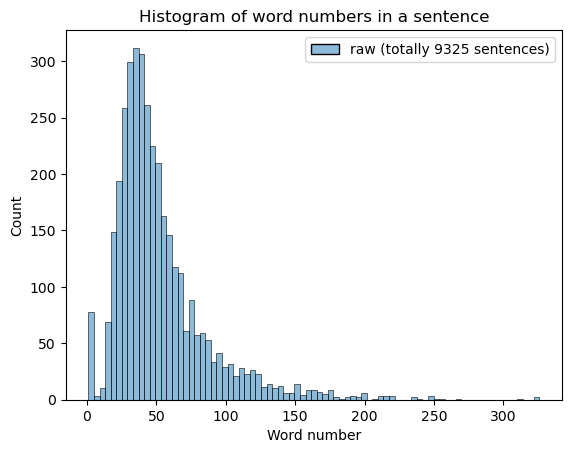

0.1655683690280066
0.027474402730375425


In [19]:
raw_word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in raw_instructions]
word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw (totally 9325 sentences)":raw_word_numbers,}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()
limit = 77
raw_word_numbers = np.array(raw_word_numbers)
print((raw_word_numbers>=limit).sum()/len(raw_word_numbers))
word_numbers = np.array(word_numbers)
print((word_numbers>=limit).sum()/len(word_numbers))

4.5150170648464165


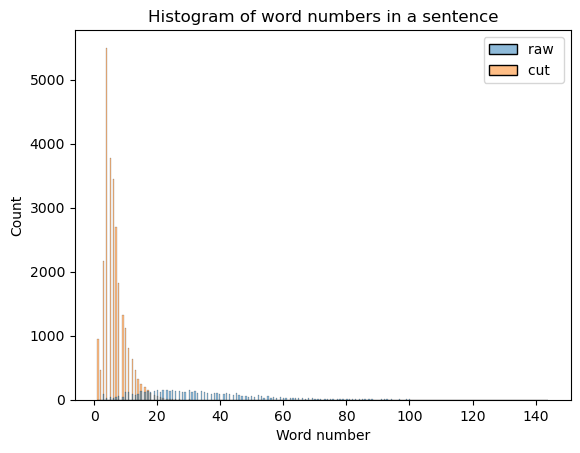

In [20]:
print(np.mean([len(v["sub_instruction"]) for v in sub_data]))
sub_instructions = [v["sub_instruction"] for v in sub_data]
raw_len_list = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
sub_len_list = [len(nltk.word_tokenize(v)) for v in list(itertools.chain.from_iterable(sub_instructions))]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw ":raw_len_list,"cut ":sub_len_list}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()

## Talk the walk

from https://github.com/facebookresearch/talkthewalk/blob/main/ttw/dict.py

16778 episodes, 16255 effective samples, 72219 samples after processing

In [24]:
import string
FOLDER = "/hy-tmp/talkthewalk/"
STOP_WORDS = ['ACTION:TURNLEFT', 'ACTION:TURNRIGHT', 'ACTION:FORWARD', 'EVALUATE_LOCATION', 'HELLO', 'HI', 'OK', 'OKAY', 'NOPE', 'YES', 'NO', 'EMM', 'AWW']
SPLITS = ["talkthewalk.full.json"]
raw_instructions = []
for split in SPLITS:
    with open(FOLDER+split,"r",encoding="utf-8") as f:
        data = json.loads(f.read())
        for ep in tqdm(data):
            inst = ""
            for msg in ep['dialog']:
                tmp = msg['text'].strip()
                if tmp.upper() not in STOP_WORDS:
                    if len(tmp)>3:
                        if tmp[-1] not in string.punctuation:
                            tmp += "."
                        inst += tmp + " "
            if len(inst)>=10:
                raw_instructions.append({"instruction_text":inst})

  0%|          | 0/16778 [00:00<?, ?it/s]

In [25]:
# Split because too long
instructions = []
cnt = 0
limit = 10
left = 3
right = 4
# limit = 1
# left = 2
# right = 5
for v in tqdm(raw_instructions):
    res = nltk.sent_tokenize(v["instruction_text"])
    res = [v for v in res if len(v)>3]
    if len(res)>=limit:
        for t in random_chunks(res,left,right):
            instructions.append(" ".join(t))
    else:
        instructions.append(" ".join(res))
instructions = [{"instruction_text":v} for v in instructions]
print(len(instructions), cnt)

  0%|          | 0/16255 [00:00<?, ?it/s]

72219 0


FSA

In [26]:
sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=nltk.sent_tokenize)

<function sent_tokenize at 0x14ebbcd2d670>


  0%|          | 0/72219 [00:00<?, ?it/s]

  0%|          | 0/72219 [00:00<?, ?it/s]

  0%|          | 0/72219 [00:00<?, ?it/s]

  0%|          | 0/72219 [00:00<?, ?it/s]

To HDF5

In [27]:
SUB_LEN = 12
INST_LEN = 77
with h5py.File('/hy-tmp/stage2/inst_sub_large.mat','a') as t:
    target_inst = t["instructions"]
    target_sub = t["sub_instructions"]
    for v in tqdm(sub_data):
        insti = v["instruction_tokens"]
        subi = v["sub_instruction_tokens"]
        
        target_inst.resize(target_inst.shape[0]+1, axis=0)
        target_inst[-1:] = np.array(insti, dtype=np.int32)
        
        target_sub.resize(target_sub.shape[0]+1, axis=0)
        target_sub[-1:] = np.array(subi, dtype=np.int32)
    print(target_inst.shape, target_sub.shape)

  0%|          | 0/72219 [00:00<?, ?it/s]

(107360, 77) (107360, 12, 77)


statics

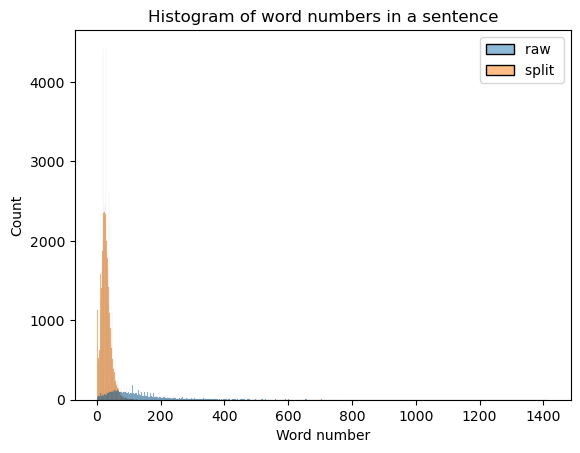

0.6338357428483543
0.010994336670405294


In [28]:
raw_word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in raw_instructions]
word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw ":raw_word_numbers,"split ":word_numbers}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()
limit = 77
raw_word_numbers = np.array(raw_word_numbers)
word_numbers = np.array(word_numbers)
print((raw_word_numbers>=77).sum()/len(raw_word_numbers))
print((word_numbers>=77).sum()/len(word_numbers))

3.763843309932289


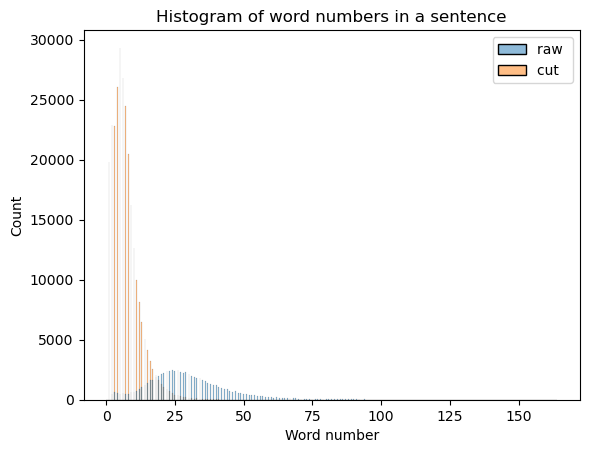

In [29]:
print(np.mean([len(v["sub_instruction"]) for v in sub_data]))
sub_instructions = [v["sub_instruction"] for v in sub_data]
raw_len_list = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]
sub_len_list = [len(nltk.word_tokenize(v)) for v in list(itertools.chain.from_iterable(sub_instructions))]
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw ":raw_len_list,"cut ":sub_len_list}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()

## Alfred
from https://github.com/askforalfred/alfred

50517 samples after processing

In [30]:
FOLDER = "/hy-tmp/alfred/json_2.1.0/"
SPLITS = "tests_seen tests_unseen train valid_seen valid_unseen".split(" ")

raw_instructions = []
for split in SPLITS:
    for path in glob.glob(FOLDER+split+"/**/*.json",recursive=True):
        with open(path,"r",encoding="utf-8") as f:
            data = json.loads(f.read())
            for annotation in data["turk_annotations"]["anns"]:
                task_desc = annotation["task_desc"].strip()
                if task_desc[-1] not in string.punctuation:
                    task_desc += "."
                high_descs = " ".join(annotation["high_descs"])
                raw_instructions.append({"instruction_text":task_desc+" "+high_descs})

In [31]:
# Split because too long
instructions = []
cnt = 0
limit = 6
left = 3
right = 4
# limit = 1
# left = 2
# right = 5
for v in tqdm(raw_instructions):
    res = nltk.sent_tokenize(v["instruction_text"])
    res = [v for v in res if len(v)>3]
    if len(res)>=limit:
        cnt += 1
        for t in random_chunks(res,left,right):
            instructions.append(" ".join(t))
    else:
        instructions.append(" ".join(res))
        
instructions = [{"instruction_text":v} for v in instructions]
print(len(instructions), cnt/len(raw_instructions))

  0%|          | 0/25728 [00:00<?, ?it/s]

50517 0.5143812189054726


FSA

In [32]:
sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=nltk.sent_tokenize)

<function sent_tokenize at 0x14ebbcd2d670>


  0%|          | 0/50517 [00:00<?, ?it/s]

  0%|          | 0/50517 [00:00<?, ?it/s]

  0%|          | 0/50517 [00:00<?, ?it/s]

  0%|          | 0/50517 [00:00<?, ?it/s]

To HDF5

In [33]:
SUB_LEN = 12
INST_LEN = 77
with h5py.File('/hy-tmp/stage2/inst_sub_large.mat','a') as t:
    target_inst = t["instructions"]
    target_sub = t["sub_instructions"]
    for v in tqdm(sub_data):
        insti = v["instruction_tokens"]
        subi = v["sub_instruction_tokens"]
        
        target_inst.resize(target_inst.shape[0]+1, axis=0)
        target_inst[-1:] = np.array(insti, dtype=np.int32)
        
        target_sub.resize(target_sub.shape[0]+1, axis=0)
        target_sub[-1:] = np.array(subi, dtype=np.int32)
    print(target_inst.shape, target_sub.shape)

  0%|          | 0/50517 [00:00<?, ?it/s]

(157877, 77) (157877, 12, 77)


statics

In [34]:
raw_word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in raw_instructions]
word_numbers = [len(nltk.word_tokenize(v["instruction_text"])) for v in instructions]

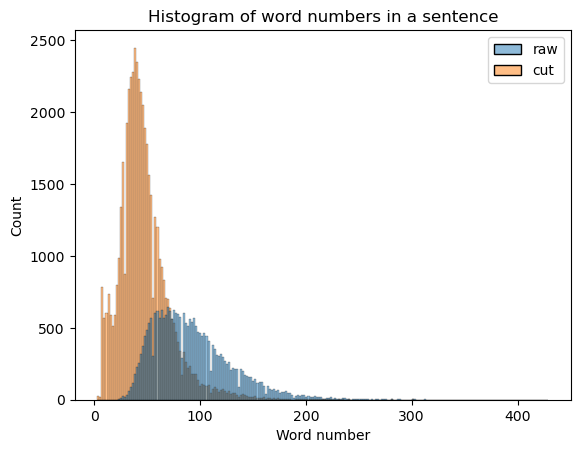

0.5966651119402985
0.09270146683294732


In [35]:
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw":raw_word_numbers,"cut":word_numbers}, ax=ax)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.show()
limit = 77
raw_word_numbers = np.array(raw_word_numbers)
print((raw_word_numbers>limit).sum()/len(raw_word_numbers))
word_numbers = np.array(word_numbers)
print((word_numbers>limit).sum()/len(word_numbers))